In [7]:
# -*- coding: utf-8 -*-
from collections import defaultdict

import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from model.s2s.seq2seq import Seq2Seq
from utils.data_loader import create_data_loader
from model.lstm.train_eval import train, evaluate
from model.lstm import lstm
import warnings

warnings.filterwarnings('ignore')

# Set random seeds
BATCH_SIZE = 128
RANDOM_SEED = 42
seq_len = 48*7
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# Defining the equipment for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'torch'

In [67]:
# --------------------------------------Start of dataset processing section-----------------------------------------#
# Importing data sets
df = pd.read_csv("./dataset/train/FLX_ZM-Mon_FLUXNET2015_FULLSET_HH_2000-2009_2-4.csv")
# Dividing the data set
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    shuffle=False
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.4,
    random_state=0,
    shuffle=False
)
mm = MinMaxScaler()
ss = StandardScaler()
normalize_func = [mm, ss]
train_data_loader = create_data_loader(df_train, seq_len=24, batch_size=BATCH_SIZE, normalize_func=normalize_func)
val_data_loader = create_data_loader(df_val, seq_len=24, batch_size=BATCH_SIZE, normalize_func=normalize_func)
test_data_loader = create_data_loader(df_test, seq_len=24, batch_size=BATCH_SIZE, normalize_func=normalize_func)
# --------------------------------------End of dataset processing section-----------------------------------------#

In [68]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,device):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim,device=device).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.relu(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [69]:
len(train_data_loader)

519

In [70]:
len(val_data_loader)

78

In [71]:
len(test_data_loader)

52

In [79]:
input_size = 14  # number of features
hidden_size = 256  # number of features in hidden state
num_layers = 1  # number of stacked lstm layers
num_classes = 48*3  # number of output classes
weight_decay = 0.0001  # 权重衰减系数
# 导入网络模型
# sm_model = lstm.LSTM(num_classes, input_size, hidden_size, num_layers, device=device)

sm_model = Seq2Seq(channel_num=input_size, hidden_size=hidden_size, num_layers=num_layers,
                   output_size=num_classes, batch_size=BATCH_SIZE, device=device)

# 将模型转移到训练设备
sm_model = sm_model.to(device)
# 定义损失函数
criterion = nn.MSELoss(reduction='mean')
criterion = criterion.to(device)
# 优化器
lr = 1e-3
optimizer = torch.optim.Adam(sm_model.parameters(), lr=lr,weight_decay=weight_decay)
# 训练的轮数
epochs = 1
best_loss = 99999.0
# 开始训练循环
history = defaultdict(list)

LSTM(
  (lstm): LSTM(14, 128, batch_first=True, dropout=0.2)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [80]:
for step in range(epochs):
    train_loss = train_model(
        model=sm_lstm,
        device=device,
        loss_fn=criterion,
        optimizer_fn=optimizer,
        data_loader=train_data_loader,
        epoch=step,
        epochs=epochs
    )

    val_loss = eval_model(
        model=sm_lstm,
        data_loader=val_data_loader,
        loss_fn=criterion,
        device=device,
        epoch=step,
        epochs=epochs,
        status='eval'
    )

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        torch.save(sm_lstm.state_dict(), './saved_models/best_model_state.pth')
        best_loss = val_loss

Epoch [ Valid 30/30 ]: 100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 153.75it/s, val_loss=0.0147]


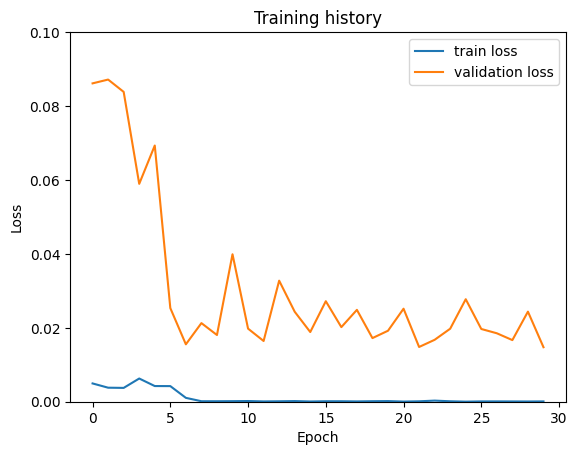

In [81]:
# loss值可视化
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.1])
plt.show()


In [87]:
# 测试模型
test_loss= eval_model(
  model=sm_lstm,
  data_loader=test_data_loader,
  loss_fn=criterion,
  device=device,
  status='test'
)
print(test_loss)


Epoch [ Test 2/20 ]: 100%|████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 104.58it/s]

0.011680478829125955


In [83]:
def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            predictions.extend(outputs)
            real_values.extend(y)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

y_prd, y = get_predictions(model=sm_lstm, data_loader=test_data_loader, device=device)


In [84]:
y

tensor([[0.0136],
        [0.0134],
        [0.0134],
        ...,
        [0.0491],
        [0.0492],
        [0.0492]])

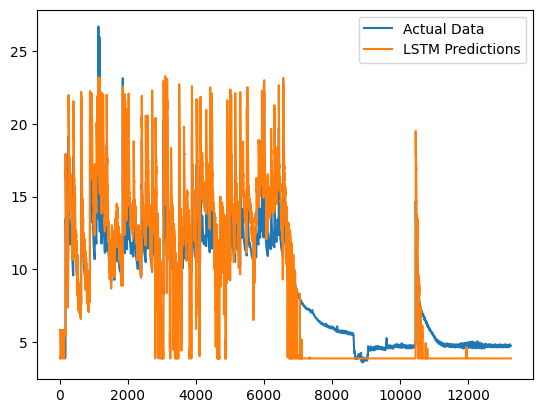

In [85]:
y = mm.inverse_transform(y)
y_prd = mm.inverse_transform(y_prd)
plt.plot(y.tolist(), label="Actual Data")
plt.plot(y_prd.tolist(), label="LSTM Predictions")
plt.legend()
# plt.savefig("small_plot.png", dpi=300)
plt.show()